<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP/MLP_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 1.44 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 12:17:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Google'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 12.5 MB/s 
     |████████████████████████████████| 170 kB 50.3 MB/s 
     |████████████████████████████████| 133 kB 58.3 MB/s 
     |████████████████████████████████| 138 kB 69.0 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 62 kB 989 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: j35xx8gd
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP/sweeps/j35xx8gd


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: evm3w60s with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
8/8 [==============================] - 14s 89ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0777 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1050
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0385 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1087
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0440 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1037
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0371 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1022
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - me

epoch,49
loss,0.00098
mean_squared_error,0.00098
mean_absolute_error,0.02349
val_loss,0.01205
val_mean_squared_error,0.01205
val_mean_absolute_error,0.086
_runtime,25
_timestamp,1627042681
_step,49
best_val_loss,0.01205


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_squared_error,▇█▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_absolute_error,▇█▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: yjreaoaf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 2s 20ms/step - loss: 0.1291 - mean_squared_error: 0.1291 - mean_absolute_error: 0.2722 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1260
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0681 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1207
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0337 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1192
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0315 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1184
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0018 - mean_squared_error: 0.

epoch,49
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01572
val_loss,0.00678
val_mean_squared_error,0.00678
val_mean_absolute_error,0.06469
_runtime,15
_timestamp,1627042707
_step,49
best_val_loss,0.00648


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▇▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rwv6adnr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 31ms/step - loss: 0.0762 - mean_squared_error: 0.0762 - mean_absolute_error: 0.2038 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1345
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0472 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1249
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0370 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1066
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0275 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0909
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_erro

epoch,65
loss,0.00046
mean_squared_error,0.00046
mean_absolute_error,0.01623
val_loss,0.00499
val_mean_squared_error,0.00499
val_mean_absolute_error,0.05578
_runtime,13
_timestamp,1627042740
_step,65
best_val_loss,0.00496


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▇▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▇▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: na21dypy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 1s 17ms/step - loss: 0.1518 - mean_squared_error: 0.1518 - mean_absolute_error: 0.3045 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1674
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - mean_absolute_error: 0.1431 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1469
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.1006 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1402
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0721 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1395
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0037 - mean_squared_erro

epoch,99
loss,0.00144
mean_squared_error,0.00144
mean_absolute_error,0.02831
val_loss,0.01719
val_mean_squared_error,0.01719
val_mean_absolute_error,0.10753
_runtime,22
_timestamp,1627042772
_step,99
best_val_loss,0.01684


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r9syzinu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 63ms/step - loss: 1.2685 - mean_squared_error: 1.2685 - mean_absolute_error: 0.6231 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1225
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0546 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1656
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1737 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1204
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0507 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1681
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0573 - mean_squared_error: 0.0573 - mea

epoch,49
loss,0.01639
mean_squared_error,0.01639
mean_absolute_error,0.10417
val_loss,0.01017
val_mean_squared_error,0.01017
val_mean_absolute_error,0.07866
_runtime,9
_timestamp,1627042793
_step,49
best_val_loss,0.00718


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▂▁▃▃▁▂▂▂▂▂▁▄▁▁▃▁▁▂▁▁▃▁▂▁▃▁▂▂▂▁▂▁▃▁▂▁▃
val_loss,▃▄▂▄▂█▂▂▂▃▂▃▁▄▁▁▃▃▁▁▁▁▂▃▁▁▅▂▁▁▂▂▂▂▁▁▁▂▁▁
val_mean_squared_error,▃▄▂▄▂█▂▂▂▃▂▃▁▄▁▁▃▃▁▁▁▁▂▃▁▁▅▂▁▁▂▂▂▂▁▁▁▂▁▁
val_mean_absolute_error,▃▅▃▅▃█▂▂▂▄▂▃▂▅▂▂▃▄▁▁▁▁▂▄▁▁▆▂▂▂▃▃▂▂▁▁▁▂▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: k45sli8u with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 1s 62ms/step - loss: 0.1552 - mean_squared_error: 0.1552 - mean_absolute_error: 0.3133 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1682
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1771 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1550
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1396 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1421
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.1118 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1308
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0083 - mean_squared_error: 0.0083 

epoch,99
loss,0.0012
mean_squared_error,0.0012
mean_absolute_error,0.02568
val_loss,0.0143
val_mean_squared_error,0.0143
val_mean_absolute_error,0.09741
_runtime,14
_timestamp,1627042818
_step,99
best_val_loss,0.01426


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mr2fzn9p with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 61ms/step - loss: 0.1537 - mean_squared_error: 0.1537 - mean_absolute_error: 0.3209 - val_loss: 0.0734 - val_mean_squared_error: 0.0734 - val_mean_absolute_error: 0.2262
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1223 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1432
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0603 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1036
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0367 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0892
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015 

epoch,79
loss,0.00035
mean_squared_error,0.00035
mean_absolute_error,0.01387
val_loss,0.00524
val_mean_squared_error,0.00524
val_mean_absolute_error,0.05689
_runtime,13
_timestamp,1627042840
_step,79
best_val_loss,0.00517


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6rl9eo5v with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 2s 19ms/step - loss: 0.7836 - mean_squared_error: 0.7836 - mean_absolute_error: 0.3312 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1072
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - mean_absolute_error: 0.1207 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1268
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0581 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0999
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0770 - val_loss: 0.0538 - val_mean_squared_error: 0.0538 - val_mean_absolute_error: 0.1999
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0190 - mean_squared_erro

epoch,23
loss,0.00396
mean_squared_error,0.00396
mean_absolute_error,0.04337
val_loss,0.00778
val_mean_squared_error,0.00778
val_mean_absolute_error,0.07213
_runtime,11
_timestamp,1627042861
_step,23
best_val_loss,0.00634


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▃▃▂▃▃▂▂▂▁▂▂▁▂▂▁▂▁▁▁▁▁
val_loss,▃▄▂█▂▂▁▁▁▁▂▂▁▁▄▆▁▁▁▃▂▁▂▁
val_mean_squared_error,▃▄▂█▂▂▁▁▁▁▂▂▁▁▄▆▁▁▁▃▂▁▂▁
val_mean_absolute_error,▃▄▃█▂▂▂▂▂▂▂▂▂▁▅▇▁▁▁▃▂▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▄▄▄▄▅▅▅▅▅▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▄▄▄▄▅▅▅▅▅▇▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: hvw11v4l with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 31ms/step - loss: 0.1072 - mean_squared_error: 0.1072 - mean_absolute_error: 0.2392 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1130
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0460 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1070
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0380 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1108
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0412 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1061
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_error: 0.

epoch,48
loss,0.00124
mean_squared_error,0.00124
mean_absolute_error,0.02687
val_loss,0.00997
val_mean_squared_error,0.00997
val_mean_absolute_error,0.07824
_runtime,12
_timestamp,1627042888
_step,48
best_val_loss,0.00935


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆█▇▇▅▄▆▆▃▃▃▃▇▂▂▃▄▃▅▃▂▃▂▂▃▁▁▁▄▂▁▁▁▂▁▁▃▁▁
val_mean_squared_error,█▆█▇▇▅▄▆▆▃▃▃▃▇▂▂▃▄▃▅▃▂▃▂▂▃▁▁▁▄▂▁▁▁▂▁▁▃▁▁
val_mean_absolute_error,█▇█▇▇▅▄▅▆▄▃▃▃▆▂▂▃▄▃▅▃▂▂▂▂▂▁▁▁▄▂▁▁▁▃▁▁▂▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qy0v1duw with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 2s 22ms/step - loss: 2.1034 - mean_squared_error: 2.1034 - mean_absolute_error: 0.9048 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1671
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1513 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0990
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0264 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0808
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0319 - val_loss: 0.0472 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1769
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.9561 - mean_squared_erro

epoch,62
loss,0.0014
mean_squared_error,0.0014
mean_absolute_error,0.02767
val_loss,0.01046
val_mean_squared_error,0.01046
val_mean_absolute_error,0.08175
_runtime,22
_timestamp,1627042925
_step,62
best_val_loss,0.00489


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: si0b1hos with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 30ms/step - loss: 0.1120 - mean_squared_error: 0.1120 - mean_absolute_error: 0.2059 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0979
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0777 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1361
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0882 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1115
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0890 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1313
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0080 - mean_squared_error: 0.

epoch,49
loss,0.00151
mean_squared_error,0.00151
mean_absolute_error,0.02472
val_loss,0.00644
val_mean_squared_error,0.00644
val_mean_absolute_error,0.06414
_runtime,12
_timestamp,1627042948
_step,49
best_val_loss,0.00632


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▄▆▄▃▄▂▃▃▂▃▃▂▂▃▃▂▂▃▁▂▃▃▂▁▃▂▂▂▁▂▂▁▃▁▂▂▂▁
val_loss,▂▄▃▄▁▂▂█▁▂▂▂▃▅▂▂▁▅▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▄▃▄▁▂▂█▁▂▂▂▃▅▂▂▁▅▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▅▄▅▂▂▂█▂▂▂▂▃▅▂▃▁▅▂▁▃▁▁▁▂▁▁▂▁▁▂▁▂▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5xnxvz6h with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 1s 60ms/step - loss: 0.2205 - mean_squared_error: 0.2205 - mean_absolute_error: 0.3862 - val_loss: 0.2238 - val_mean_squared_error: 0.2238 - val_mean_absolute_error: 0.4112
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1710 - mean_squared_error: 0.1710 - mean_absolute_error: 0.3285 - val_loss: 0.1776 - val_mean_squared_error: 0.1776 - val_mean_absolute_error: 0.3557
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1410 - mean_squared_error: 0.1410 - mean_absolute_error: 0.2855 - val_loss: 0.1365 - val_mean_squared_error: 0.1365 - val_mean_absolute_error: 0.2998
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1011 - mean_squared_error: 0.1011 - mean_absolute_error: 0.2409 - val_loss: 0.1025 - val_mean_squared_error: 0.1025 - val_mean_absolute_error: 0.2526
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0848 - mean_squared_error: 0.0848 

epoch,63
loss,0.00248
mean_squared_error,0.00248
mean_absolute_error,0.03831
val_loss,0.02505
val_mean_squared_error,0.02505
val_mean_absolute_error,0.13086
_runtime,11
_timestamp,1627042970
_step,63
best_val_loss,0.02473


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▇▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gxiqeyrw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 61ms/step - loss: 0.1883 - mean_squared_error: 0.1883 - mean_absolute_error: 0.3467 - val_loss: 0.0643 - val_mean_squared_error: 0.0643 - val_mean_absolute_error: 0.1999
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - mean_absolute_error: 0.1931 - val_loss: 0.0461 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1812
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0463 - mean_squared_error: 0.0463 - mean_absolute_error: 0.1810 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1624
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.1550 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1478
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - mea

epoch,49
loss,0.00171
mean_squared_error,0.00171
mean_absolute_error,0.03098
val_loss,0.01985
val_mean_squared_error,0.01985
val_mean_absolute_error,0.11623
_runtime,11
_timestamp,1627042994
_step,49
best_val_loss,0.01985


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: d1eg43zu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 32ms/step - loss: 0.1919 - mean_squared_error: 0.1919 - mean_absolute_error: 0.3537 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1362
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.1052 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1204
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0695 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1234
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0386 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1192
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_erro

epoch,99
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01476
val_loss,0.00565
val_mean_squared_error,0.00565
val_mean_absolute_error,0.0606
_runtime,21
_timestamp,1627043026
_step,99
best_val_loss,0.00552


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qzf7mksp with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 21ms/step - loss: 1.2322 - mean_squared_error: 1.2322 - mean_absolute_error: 0.7273 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1525
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0510 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1618 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1065
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0451 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0921
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0415 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0795
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.

epoch,49
loss,0.03054
mean_squared_error,0.03054
mean_absolute_error,0.11599
val_loss,0.02093
val_mean_squared_error,0.02093
val_mean_absolute_error,0.12261
_runtime,20
_timestamp,1627043057
_step,49
best_val_loss,0.00586


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
mean_absolute_error,▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▄▂▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁
val_mean_absolute_error,▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▂▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: edvsenrx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 35ms/step - loss: 0.0936 - mean_squared_error: 0.0936 - mean_absolute_error: 0.2281 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1383
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0829 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1230
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0420 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1217
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0343 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1191
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_erro

epoch,99
loss,0.00033
mean_squared_error,0.00033
mean_absolute_error,0.01346
val_loss,0.00536
val_mean_squared_error,0.00536
val_mean_absolute_error,0.058
_runtime,22
_timestamp,1627043091
_step,99
best_val_loss,0.00523


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r8f3ux3a with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 1s 18ms/step - loss: 0.2040 - mean_squared_error: 0.2040 - mean_absolute_error: 0.3544 - val_loss: 0.1065 - val_mean_squared_error: 0.1065 - val_mean_absolute_error: 0.2562
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0713 - mean_squared_error: 0.0713 - mean_absolute_error: 0.2178 - val_loss: 0.0485 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1838
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0525 - mean_squared_error: 0.0525 - mean_absolute_error: 0.1916 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1726
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1679 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1530
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0236 - mean_squared_error: 0.

epoch,49
loss,0.00171
mean_squared_error,0.00171
mean_absolute_error,0.03136
val_loss,0.01883
val_mean_squared_error,0.01883
val_mean_absolute_error,0.11316
_runtime,15
_timestamp,1627043118
_step,49
best_val_loss,0.01883


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: fjsklu9j with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 66ms/step - loss: 0.1955 - mean_squared_error: 0.1955 - mean_absolute_error: 0.3590 - val_loss: 0.0814 - val_mean_squared_error: 0.0814 - val_mean_absolute_error: 0.2303
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1573 - val_loss: 0.0518 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1872
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.1145 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1410
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0818 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1426
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0054 

epoch,99
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.0152
val_loss,0.00626
val_mean_squared_error,0.00626
val_mean_absolute_error,0.06376
_runtime,18
_timestamp,1627043148
_step,99
best_val_loss,0.00626


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vupx52yn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 31ms/step - loss: 0.0695 - mean_squared_error: 0.0695 - mean_absolute_error: 0.1753 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1702
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0681 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1497
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0478 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1557
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0522 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1502
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_squared_error: 0.

epoch,49
loss,0.0021
mean_squared_error,0.0021
mean_absolute_error,0.03674
val_loss,0.01299
val_mean_squared_error,0.01299
val_mean_absolute_error,0.08934
_runtime,13
_timestamp,1627043173
_step,49
best_val_loss,0.0087


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▂▂▁▂▁▂▁▁▂▁▂▁▂
val_loss,▆▅▅▅▃█▃▃▃▂▂▂▃▂▂▂▂▄▃▂▂▂▁▁▂▃▂▂▂▂▁▁▃▂▁▁▁▁▁▂
val_mean_squared_error,▆▅▅▅▃█▃▃▃▂▂▂▃▂▂▂▂▄▃▂▂▂▁▁▂▃▂▂▂▂▁▁▃▂▁▁▁▁▁▂
val_mean_absolute_error,▇▆▆▆▄█▄▄▃▃▃▃▃▃▂▂▂▄▄▂▃▂▂▂▂▄▂▃▂▂▂▁▄▃▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bgi2jdtb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 32ms/step - loss: 0.1847 - mean_squared_error: 0.1847 - mean_absolute_error: 0.3191 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1205
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1110 - val_loss: 0.1040 - val_mean_squared_error: 0.1040 - val_mean_absolute_error: 0.2762
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0368 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1529 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1264
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1104 - val_loss: 0.1181 - val_mean_squared_error: 0.1181 - val_mean_absolute_error: 0.2985
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0315 - mean_squared_erro

epoch,44
loss,0.00471
mean_squared_error,0.00471
mean_absolute_error,0.0484
val_loss,0.02137
val_mean_squared_error,0.02137
val_mean_absolute_error,0.11988
_runtime,13
_timestamp,1627043202
_step,44
best_val_loss,0.01166


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▄▃▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁
val_loss,▂▇▂█▂▂▂▂▃▁▁▄▂▂▁▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂
val_mean_squared_error,▂▇▂█▂▂▂▂▃▁▁▄▂▂▁▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂
val_mean_absolute_error,▂▇▂█▂▃▃▂▄▂▂▅▃▂▂▃▃▂▂▃▂▁▂▂▁▁▁▁▁▃▁▁▁▁▂▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: deiuiwo8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 2s 20ms/step - loss: 0.1536 - mean_squared_error: 0.1536 - mean_absolute_error: 0.3037 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1759
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1583 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1353
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0538 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1362
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0371 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1328
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0023 - mean_squared_error: 0.

epoch,49
loss,0.00121
mean_squared_error,0.00121
mean_absolute_error,0.02598
val_loss,0.01446
val_mean_squared_error,0.01446
val_mean_absolute_error,0.09825
_runtime,16
_timestamp,1627043232
_step,49
best_val_loss,0.01446


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g60myc4l with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 1s 31ms/step - loss: 0.1494 - mean_squared_error: 0.1494 - mean_absolute_error: 0.3095 - val_loss: 0.0523 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1926
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - mean_absolute_error: 0.1806 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1631
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1244 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1417
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0630 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1430
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.

epoch,49
loss,0.00179
mean_squared_error,0.00179
mean_absolute_error,0.03185
val_loss,0.02094
val_mean_squared_error,0.02094
val_mean_absolute_error,0.1192
_runtime,13
_timestamp,1627043259
_step,49
best_val_loss,0.02081


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: go6e4l0o with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: 0.0543 - mean_squared_error: 0.0543 - mean_absolute_error: 0.1409 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1421
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0501 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1193
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0529 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1199
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0418 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1123
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_erro

epoch,75
loss,0.00119
mean_squared_error,0.00119
mean_absolute_error,0.0266
val_loss,0.00758
val_mean_squared_error,0.00758
val_mean_absolute_error,0.06982
_runtime,23
_timestamp,1627043299
_step,75
best_val_loss,0.00672


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▄▂▂▂▂▂▂▄▂▂▂▂▂▂▁▁▁▂▁▂▁▁▂▁▁▁▂▁▁▂▁▁▁▁▂▁
val_mean_squared_error,█▅▅▅▄▂▂▂▂▂▂▄▂▂▂▂▂▂▁▁▁▂▁▂▁▁▂▁▁▁▂▁▁▂▁▁▁▁▂▁
val_mean_absolute_error,█▆▅▅▄▃▃▂▃▂▂▅▂▂▂▃▂▂▁▂▂▂▁▃▁▁▂▁▁▁▂▂▂▃▁▁▁▁▂▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: x8mzrb64 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 121ms/step - loss: 0.2148 - mean_squared_error: 0.2148 - mean_absolute_error: 0.3799 - val_loss: 0.1158 - val_mean_squared_error: 0.1158 - val_mean_absolute_error: 0.2813
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0623 - mean_squared_error: 0.0623 - mean_absolute_error: 0.1861 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1381
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0688 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1386
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0564 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1367
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.00

epoch,99
loss,0.00063
mean_squared_error,0.00063
mean_absolute_error,0.01872
val_loss,0.00835
val_mean_squared_error,0.00835
val_mean_absolute_error,0.07192
_runtime,19
_timestamp,1627043332
_step,99
best_val_loss,0.00821


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rxah3ica with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 34ms/step - loss: 0.2091 - mean_squared_error: 0.2091 - mean_absolute_error: 0.3582 - val_loss: 0.0363 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1528
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0902 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1414
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1199 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1217
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0833 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1330
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0168 - mean_squared_erro

epoch,53
loss,0.00249
mean_squared_error,0.00249
mean_absolute_error,0.03782
val_loss,0.01757
val_mean_squared_error,0.01757
val_mean_absolute_error,0.1043
_runtime,15
_timestamp,1627043361
_step,53
best_val_loss,0.01073


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▂▃▃▃▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▂▄▂█▃▂▆▂▂▂▂▁▁▁▂▁▂▂▁▂▂▁▁▁▁▁▂▁▃▁▁▂▁▁▁▁▁▂
val_mean_squared_error,▃▃▂▄▂█▃▂▆▂▂▂▂▁▁▁▂▁▂▂▁▂▂▁▁▁▁▁▂▁▃▁▁▂▁▁▁▁▁▂
val_mean_absolute_error,▄▃▃▄▃█▄▃▆▂▂▂▃▂▂▂▃▂▂▂▂▃▂▁▁▁▁▂▂▁▄▂▁▃▁▂▁▁▁▂
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ccuo9779 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 37ms/step - loss: 0.1443 - mean_squared_error: 0.1443 - mean_absolute_error: 0.2760 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1111
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0440 - val_loss: 0.0359 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1578
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0572 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0814
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0358 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0914
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_err

epoch,41
loss,0.00055
mean_squared_error,0.00055
mean_absolute_error,0.01754
val_loss,0.00622
val_mean_squared_error,0.00622
val_mean_absolute_error,0.06312
_runtime,15
_timestamp,1627043389
_step,41
best_val_loss,0.00539


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,▇▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁
mean_squared_error,▇▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▂▁▁▂▇▁▁▁▁▁▁▂▁▁▁▂▁▁▂▂▁▁▁▁▁▂█▃▁▁▁▁▁
val_loss,▄▇▂▂▂▂▃▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▄█▂▂▁▁▁▁
val_mean_squared_error,▄▇▂▂▂▂▃▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▄█▂▂▁▁▁▁
val_mean_absolute_error,▄▇▂▃▂▃▄▂▂▂▄▃▃▂▁▁▁▁▂▁▁▁▁▁▂▂▂▁▁▁▁▂▅█▂▃▂▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: f7qywryh with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 67ms/step - loss: 0.2220 - mean_squared_error: 0.2220 - mean_absolute_error: 0.3884 - val_loss: 0.1679 - val_mean_squared_error: 0.1679 - val_mean_absolute_error: 0.3509
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1136 - mean_squared_error: 0.1136 - mean_absolute_error: 0.2626 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1507
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1075 - val_loss: 0.0514 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1864
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.1163 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1327
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0095 - mean_squared_error: 0.0095

epoch,99
loss,0.00041
mean_squared_error,0.00041
mean_absolute_error,0.01487
val_loss,0.00617
val_mean_squared_error,0.00617
val_mean_absolute_error,0.06245
_runtime,17
_timestamp,1627043421
_step,99
best_val_loss,0.00617


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wfvaw5wy with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 61ms/step - loss: 0.2547 - mean_squared_error: 0.2547 - mean_absolute_error: 0.2782 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1176
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0892 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1141
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0556 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1090
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0524 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1223
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0091 - mean_squared_error: 0.

epoch,36
loss,0.00312
mean_squared_error,0.00312
mean_absolute_error,0.04417
val_loss,0.00887
val_mean_squared_error,0.00887
val_mean_absolute_error,0.07275
_runtime,14
_timestamp,1627043450
_step,36
best_val_loss,0.00677


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▄▄▃▃▂▂▃▂▃▂▃▁▂▃▁▃▁▂▂▁▂▂▂▁▂▂▂▂▂▁▂▂
val_loss,▄▄▃▅▂▂▃▃█▄▃▂▁▁▂▄▁▁▁▂▁▂▁▂▁▂▁▁▂▂▁▂▁▁▂▁▁
val_mean_squared_error,▄▄▃▅▂▂▃▃█▄▃▂▁▁▂▄▁▁▁▂▁▂▁▂▁▂▁▁▂▂▁▂▁▁▂▁▁
val_mean_absolute_error,▅▄▄▅▃▃▃▃█▄▃▂▂▂▂▅▂▂▂▂▁▂▁▃▁▃▁▁▂▃▁▂▁▁▂▁▂
_runtime,▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pdu93squ with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 35ms/step - loss: 0.1344 - mean_squared_error: 0.1344 - mean_absolute_error: 0.2752 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1497
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0543 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1537
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0445 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1548
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0430 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1412
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.

epoch,49
loss,0.00051
mean_squared_error,0.00051
mean_absolute_error,0.01678
val_loss,0.0075
val_mean_squared_error,0.0075
val_mean_absolute_error,0.07012
_runtime,16
_timestamp,1627043481
_step,49
best_val_loss,0.0075


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁
val_loss,▇██▆▇▆▅▄▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,▇██▆▇▆▅▄▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,███▇▇▆▆▄▄▃▃▃▃▃▃▄▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: df8hoxsj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 33ms/step - loss: 0.1548 - mean_squared_error: 0.1548 - mean_absolute_error: 0.3149 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1401
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.1041 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1353
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0680 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1400
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0438 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1382
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.

epoch,49
loss,0.00059
mean_squared_error,0.00059
mean_absolute_error,0.01799
val_loss,0.00779
val_mean_squared_error,0.00779
val_mean_absolute_error,0.07033
_runtime,16
_timestamp,1627043515
_step,49
best_val_loss,0.00779


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▇▇▆▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇█▇▇▆▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,████▇▇▇▆▆▅▅▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xp02g4dh with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: 0.2179 - mean_squared_error: 0.2179 - mean_absolute_error: 0.2562 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0996
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0484 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0950
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0400 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0860
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0475 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0843
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_squared_erro

epoch,51
loss,0.0005
mean_squared_error,0.0005
mean_absolute_error,0.01648
val_loss,0.00586
val_mean_squared_error,0.00586
val_mean_absolute_error,0.06184
_runtime,22
_timestamp,1627043551
_step,51
best_val_loss,0.00522


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▃▄▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▃▃█▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▄▃▃█▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▄▃▃█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: p0ci187o with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 66ms/step - loss: 0.1017 - mean_squared_error: 0.1017 - mean_absolute_error: 0.2500 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1279
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0876 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1002
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0539 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0843
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0371 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0867
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0

epoch,90
loss,0.00054
mean_squared_error,0.00054
mean_absolute_error,0.01811
val_loss,0.00592
val_mean_squared_error,0.00592
val_mean_absolute_error,0.059
_runtime,19
_timestamp,1627043587
_step,90
best_val_loss,0.00523


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,▃▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▃▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▅▂▂▁▂▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▆▂▂▃▂▂▄▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▆▂▂▃▂▂▄▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▆▂▃▃▃▃▅▂▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: xzd8fs2c with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
31/31 [==============================] - 1s 18ms/step - loss: 0.1408 - mean_squared_error: 0.1408 - mean_absolute_error: 0.2913 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1690
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1502 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1219
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0499 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1213
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0356 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1197
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_squared_erro

epoch,99
loss,0.00074
mean_squared_error,0.00074
mean_absolute_error,0.01979
val_loss,0.00961
val_mean_squared_error,0.00961
val_mean_absolute_error,0.07772
_runtime,30
_timestamp,1627043647
_step,99
best_val_loss,0.00954


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: myst66bq with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 34ms/step - loss: 0.3217 - mean_squared_error: 0.3217 - mean_absolute_error: 0.3950 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1237
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0555 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0849
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0290 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0816
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 9.9674e-04 - mean_squared_error: 9.9674e-04 - mean_absolute_error: 0.0234 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0790
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 8.4328e-04 - mean_

epoch,67
loss,0.00032
mean_squared_error,0.00032
mean_absolute_error,0.0129
val_loss,0.00474
val_mean_squared_error,0.00474
val_mean_absolute_error,0.05445
_runtime,20
_timestamp,1627043682
_step,67
best_val_loss,0.00471


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cf481jnm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 21ms/step - loss: 0.0761 - mean_squared_error: 0.0761 - mean_absolute_error: 0.1855 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1269
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0352 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1136
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0391 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1131
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0314 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0983
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.

epoch,49
loss,0.00046
mean_squared_error,0.00046
mean_absolute_error,0.01597
val_loss,0.00623
val_mean_squared_error,0.00623
val_mean_absolute_error,0.06247
_runtime,22
_timestamp,1627043723
_step,49
best_val_loss,0.00623


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▁▃▁▂▁▁▂▁▁▂▂▁▁▁▂▁▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁
val_loss,█▆▆▅▅▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▅▅▄▃▃▂▃▂▂▂▂▂▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: c2y0vspe with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 67ms/step - loss: 2.5764 - mean_squared_error: 2.5764 - mean_absolute_error: 1.0769 - val_loss: 1.0486 - val_mean_squared_error: 1.0486 - val_mean_absolute_error: 0.9556
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3620 - mean_squared_error: 0.3620 - mean_absolute_error: 0.4231 - val_loss: 0.0537 - val_mean_squared_error: 0.0537 - val_mean_absolute_error: 0.1916
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.1137 - mean_squared_error: 0.1137 - mean_absolute_error: 0.2480 - val_loss: 0.0585 - val_mean_squared_error: 0.0585 - val_mean_absolute_error: 0.2017
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2419 - mean_squared_error: 0.2419 - mean_absolute_error: 0.3243 - val_loss: 0.0467 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1754
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - 

epoch,49
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.02547
val_loss,0.00714
val_mean_squared_error,0.00714
val_mean_absolute_error,0.0671
_runtime,15
_timestamp,1627043759
_step,49
best_val_loss,0.00688


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▁▁▁▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▁▁▁▆▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 93hemgfm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 33ms/step - loss: 0.0928 - mean_squared_error: 0.0928 - mean_absolute_error: 0.2197 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1659
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0729 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1247
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0751 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1602
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0781 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - val_mean_absolute_error: 0.2117
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0145 - mean_squared_error: 0

epoch,49
loss,0.00181
mean_squared_error,0.00181
mean_absolute_error,0.03261
val_loss,0.00912
val_mean_squared_error,0.00912
val_mean_absolute_error,0.07512
_runtime,17
_timestamp,1627043792
_step,49
best_val_loss,0.00838


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▄▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▄▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▂▅▃▂▂▃▂▁▁▂▃▂▂▂▁▂▁▂▂▂▂▁▃▁▂▁▁▂▁▂▁▂▁▂▁▂
val_loss,▅▃▅█▂▆▂▂▃▂▂▄▂▃▂▂▁▁▂▃▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▃▅█▂▆▂▂▃▂▂▄▂▃▂▂▁▁▂▃▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▄▅█▃▇▃▃▄▂▂▅▂▃▂▃▂▂▂▃▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eqiw0r2c with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 66ms/step - loss: 0.2134 - mean_squared_error: 0.2134 - mean_absolute_error: 0.3601 - val_loss: 0.0446 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1690
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1264 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1096
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0606 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1089
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0517 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0982
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mea

epoch,49
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.01387
val_loss,0.00568
val_mean_squared_error,0.00568
val_mean_absolute_error,0.05988
_runtime,14
_timestamp,1627043823
_step,49
best_val_loss,0.00568


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dk0r0sy1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 2s 19ms/step - loss: 0.3128 - mean_squared_error: 0.3128 - mean_absolute_error: 0.2228 - val_loss: 0.0553 - val_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.1953
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1108 - val_loss: 0.0490 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1881
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1252 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1398
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0780 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0799
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0091 - mean_squared_error: 0.

epoch,24
loss,0.00204
mean_squared_error,0.00204
mean_absolute_error,0.03506
val_loss,0.0207
val_mean_squared_error,0.0207
val_mean_absolute_error,0.11689
_runtime,13
_timestamp,1627043857
_step,24
best_val_loss,0.00574


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▃▃▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▂▂▃▁▁▂▁▁▂▁▂▁▁▁▁▁▂▂▁▁▁▃
val_mean_squared_error,█▇▄▂▂▃▁▁▂▁▁▂▁▂▁▁▁▁▁▂▂▁▁▁▃
val_mean_absolute_error,██▅▂▂▄▁▁▃▂▂▂▂▂▁▁▁▁▁▃▃▁▁▁▄
_runtime,▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇▇█████
_timestamp,▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇▇█████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: jsccbdno with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 2s 21ms/step - loss: 0.1959 - mean_squared_error: 0.1959 - mean_absolute_error: 0.3558 - val_loss: 0.1157 - val_mean_squared_error: 0.1157 - val_mean_absolute_error: 0.2709
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0809 - mean_squared_error: 0.0809 - mean_absolute_error: 0.2263 - val_loss: 0.0495 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1809
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1886 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1735
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1714 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1687
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0397 - mean_squared_error: 0.

epoch,25
loss,0.00209
mean_squared_error,0.00209
mean_absolute_error,0.03483
val_loss,0.02261
val_mean_squared_error,0.02261
val_mean_absolute_error,0.12429
_runtime,15
_timestamp,1627043887
_step,25
best_val_loss,0.02259


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: ur2z6ye9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 65ms/step - loss: 0.1884 - mean_squared_error: 0.1884 - mean_absolute_error: 0.3365 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1045
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0649 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1143
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0553 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0972
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0366 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1022
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021

epoch,99
loss,0.00029
mean_squared_error,0.00029
mean_absolute_error,0.01245
val_loss,0.00466
val_mean_squared_error,0.00466
val_mean_absolute_error,0.05248
_runtime,19
_timestamp,1627043920
_step,99
best_val_loss,0.00458


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xgxdzacp with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 2s 19ms/step - loss: 1.5451 - mean_squared_error: 1.5451 - mean_absolute_error: 0.8574 - val_loss: 0.0593 - val_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.1941
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0897 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0821
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0365 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0700
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 6.1319e-04 - mean_squared_error: 6.1319e-04 - mean_absolute_error: 0.0192 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0671
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 6.5967e-04 - mean_squar

epoch,22
loss,0.00049
mean_squared_error,0.00049
mean_absolute_error,0.01711
val_loss,0.00579
val_mean_squared_error,0.00579
val_mean_absolute_error,0.05928
_runtime,14
_timestamp,1627043960
_step,22
best_val_loss,0.00513


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▅▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▅▇▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: ylgfshq0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 32ms/step - loss: 0.3768 - mean_squared_error: 0.3768 - mean_absolute_error: 0.4045 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1119
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0638 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1043
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0367 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0999
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0276 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0904
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0010 - mean_squared_error: 0.

epoch,49
loss,0.00041
mean_squared_error,0.00041
mean_absolute_error,0.01469
val_loss,0.00506
val_mean_squared_error,0.00506
val_mean_absolute_error,0.0563
_runtime,17
_timestamp,1627043995
_step,49
best_val_loss,0.00506


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3g3tchq7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 64ms/step - loss: 3.2510 - mean_squared_error: 3.2510 - mean_absolute_error: 1.2321 - val_loss: 0.6717 - val_mean_squared_error: 0.6717 - val_mean_absolute_error: 0.7397
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.3025 - mean_squared_error: 0.3025 - mean_absolute_error: 0.4239 - val_loss: 0.1484 - val_mean_squared_error: 0.1484 - val_mean_absolute_error: 0.3343
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0814 - mean_squared_error: 0.0814 - mean_absolute_error: 0.2272 - val_loss: 0.2006 - val_mean_squared_error: 0.2006 - val_mean_absolute_error: 0.3837
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0715 - mean_squared_error: 0.0715 - mean_absolute_error: 0.1936 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0771
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0031 - mean_squared_error: 0.00

epoch,17
loss,0.00118
mean_squared_error,0.00118
mean_absolute_error,0.02681
val_loss,0.00951
val_mean_squared_error,0.00951
val_mean_absolute_error,0.07673
_runtime,11
_timestamp,1627044021
_step,17
best_val_loss,0.00862


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▅▃▂▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▅▃▂▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▂▇▅▃▃▁▁▁
val_loss,▃▁▁▁▁▁▁▁▁▁█▂▂▂▁▁▁▁
val_mean_squared_error,▃▁▁▁▁▁▁▁▁▁█▂▂▂▁▁▁▁
val_mean_absolute_error,▄▂▂▁▁▁▁▁▁▁█▃▃▃▂▁▁▁
_runtime,▁▁▅▅▅▅▅▅▅▅████████
_timestamp,▁▁▅▅▅▅▅▅▅▅████████
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: 9nv0rp58 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 22ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - mean_absolute_error: 0.1799 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1478
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0641 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1068
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0665 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0937
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0367 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0952
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0

epoch,46
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01556
val_loss,0.00597
val_mean_squared_error,0.00597
val_mean_absolute_error,0.06243
_runtime,23
_timestamp,1627044059
_step,46
best_val_loss,0.00523


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
mean_squared_error,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
mean_absolute_error,█▃▄▂▂▃▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁
val_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▅▄▄▃▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁
_runtime,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xa5gvf29 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 2s 20ms/step - loss: 0.1454 - mean_squared_error: 0.1454 - mean_absolute_error: 0.2942 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1309
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0644 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1270
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0359 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1292
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0338 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1252
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_erro

epoch,99
loss,0.00033
mean_squared_error,0.00033
mean_absolute_error,0.01349
val_loss,0.00498
val_mean_squared_error,0.00498
val_mean_absolute_error,0.05437
_runtime,35
_timestamp,1627044109
_step,99
best_val_loss,0.0049


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▄▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▅▄▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r7hvk8cb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 34ms/step - loss: 0.0985 - mean_squared_error: 0.0985 - mean_absolute_error: 0.2342 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1378
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0497 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1407
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0413 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1293
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0343 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1386
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 

epoch,49
loss,0.00154
mean_squared_error,0.00154
mean_absolute_error,0.0297
val_loss,0.00795
val_mean_squared_error,0.00795
val_mean_absolute_error,0.07083
_runtime,17
_timestamp,1627044140
_step,49
best_val_loss,0.00783


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▂▁▂
val_loss,██▇█▆▆▅▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▂▃▁▁▁▁▂▁▁▂▁▁▁
val_mean_squared_error,██▇█▆▆▅▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▂▃▁▁▁▁▂▁▁▂▁▁▁
val_mean_absolute_error,██▇█▆▆▅▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▂▄▁▁▁▁▂▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3twyq9m1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 2s 21ms/step - loss: 0.2085 - mean_squared_error: 0.2085 - mean_absolute_error: 0.3682 - val_loss: 0.1327 - val_mean_squared_error: 0.1327 - val_mean_absolute_error: 0.2965
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0889 - mean_squared_error: 0.0889 - mean_absolute_error: 0.2315 - val_loss: 0.0469 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1736
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1737 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1594
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.1570 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1517
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0281 - mean_squared_error: 0.

epoch,24
loss,0.00186
mean_squared_error,0.00186
mean_absolute_error,0.03233
val_loss,0.02033
val_mean_squared_error,0.02033
val_mean_absolute_error,0.11857
_runtime,15
_timestamp,1627044171
_step,24
best_val_loss,0.02017


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: df33q94d with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 1s 34ms/step - loss: 0.1988 - mean_squared_error: 0.1988 - mean_absolute_error: 0.3627 - val_loss: 0.1775 - val_mean_squared_error: 0.1775 - val_mean_absolute_error: 0.3557
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.1351 - mean_squared_error: 0.1351 - mean_absolute_error: 0.2810 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - val_mean_absolute_error: 0.2381
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0657 - mean_squared_error: 0.0657 - mean_absolute_error: 0.2008 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1745
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1606 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1624
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0321 - mean_squared_erro

epoch,29
loss,0.0023
mean_squared_error,0.0023
mean_absolute_error,0.0363
val_loss,0.02489
val_mean_squared_error,0.02489
val_mean_absolute_error,0.13066
_runtime,12
_timestamp,1627044198
_step,29
best_val_loss,0.02445


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆███████
_timestamp,▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆███████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: niukhzpy with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 65ms/step - loss: 0.1437 - mean_squared_error: 0.1437 - mean_absolute_error: 0.3000 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1285
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0738 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1275
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0481 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1414
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0475 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1279
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0022 - mean_squared_error: 0.00

epoch,99
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.02257
val_loss,0.00811
val_mean_squared_error,0.00811
val_mean_absolute_error,0.07004
_runtime,21
_timestamp,1627044234
_step,99
best_val_loss,0.00748


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
val_loss,▆█▅▆▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▅▆▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▅▆▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: c6v076h5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 21ms/step - loss: 0.1348 - mean_squared_error: 0.1348 - mean_absolute_error: 0.2777 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1313
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0370 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1304
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0367 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1176
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0323 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1144
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.

epoch,49
loss,0.00061
mean_squared_error,0.00061
mean_absolute_error,0.01826
val_loss,0.00712
val_mean_squared_error,0.00712
val_mean_absolute_error,0.06689
_runtime,24
_timestamp,1627044278
_step,49
best_val_loss,0.00686


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▆▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▆▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dzmcpuvc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 2s 22ms/step - loss: 0.1313 - mean_squared_error: 0.1313 - mean_absolute_error: 0.2763 - val_loss: 0.0454 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1729
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0901 - val_loss: 0.0524 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.1888
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0965 - val_loss: 0.1038 - val_mean_squared_error: 0.1038 - val_mean_absolute_error: 0.2857
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1014 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1098
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0103 - mean_squared_error: 0.

epoch,49
loss,0.0026
mean_squared_error,0.0026
mean_absolute_error,0.04001
val_loss,0.0107
val_mean_squared_error,0.0107
val_mean_absolute_error,0.08028
_runtime,22
_timestamp,1627044344
_step,49
best_val_loss,0.00836


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄█▂▃▃▂▂▂▂▁▂▁▁▁▁▁▂▁▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▄▄█▂▃▃▂▂▂▂▁▂▁▁▁▁▁▂▁▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▄▅█▂▃▃▂▂▃▂▂▂▂▂▂▂▁▂▁▂▃▂▃▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sj2o5kly with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 71ms/step - loss: 0.2060 - mean_squared_error: 0.2060 - mean_absolute_error: 0.3721 - val_loss: 0.1765 - val_mean_squared_error: 0.1765 - val_mean_absolute_error: 0.3611
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1175 - mean_squared_error: 0.1175 - mean_absolute_error: 0.2700 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1465
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0930 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1323
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0617 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1266
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - 

epoch,49
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02566
val_loss,0.01063
val_mean_squared_error,0.01063
val_mean_absolute_error,0.08222
_runtime,15
_timestamp,1627044381
_step,49
best_val_loss,0.01017


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: h4h0yx5f with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 67ms/step - loss: 1.4993 - mean_squared_error: 1.4993 - mean_absolute_error: 0.8641 - val_loss: 0.7203 - val_mean_squared_error: 0.7203 - val_mean_absolute_error: 0.7924
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.2198 - mean_squared_error: 0.2198 - mean_absolute_error: 0.3520 - val_loss: 0.0625 - val_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.2037
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0888 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1197
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0508 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0882
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - me

epoch,49
loss,0.00033
mean_squared_error,0.00033
mean_absolute_error,0.01335
val_loss,0.00447
val_mean_squared_error,0.00447
val_mean_absolute_error,0.05141
_runtime,15
_timestamp,1627044411
_step,49
best_val_loss,0.00434


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xx04zm7j with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 65ms/step - loss: 0.2304 - mean_squared_error: 0.2304 - mean_absolute_error: 0.3126 - val_loss: 0.0725 - val_mean_squared_error: 0.0725 - val_mean_absolute_error: 0.2213
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1454 - val_loss: 0.0423 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1678
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0810 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1251
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0463 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1269
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - 

epoch,45
loss,0.00076
mean_squared_error,0.00076
mean_absolute_error,0.02065
val_loss,0.00635
val_mean_squared_error,0.00635
val_mean_absolute_error,0.06183
_runtime,14
_timestamp,1627044439
_step,45
best_val_loss,0.0058


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
mean_squared_error,▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
mean_absolute_error,▆▃▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂█▂▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁
val_mean_squared_error,█▅▃▃▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▃▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▂▂▁▂▁▁▁▂▁▁▁▁▄▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 050vbgq2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 37ms/step - loss: 0.1221 - mean_squared_error: 0.1221 - mean_absolute_error: 0.2650 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1347
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0925 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1315
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0439 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1262
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0363 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1235
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0

epoch,49
loss,0.00045
mean_squared_error,0.00045
mean_absolute_error,0.01556
val_loss,0.00595
val_mean_squared_error,0.00595
val_mean_absolute_error,0.06152
_runtime,17
_timestamp,1627044471
_step,49
best_val_loss,0.00595


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▆▆▆▅▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▇▆▆▆▆▅▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4wx4fhnh with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 2s 19ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1251 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0904
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0242 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0815
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 9.3427e-04 - mean_squared_error: 9.3427e-04 - mean_absolute_error: 0.0224 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0768
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 7.5157e-04 - mean_squared_error: 7.5157e-04 - mean_absolute_error: 0.0201 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0728
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 7.1091e-04 - me

epoch,49
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01442
val_loss,0.00565
val_mean_squared_error,0.00565
val_mean_absolute_error,0.06051
_runtime,20
_timestamp,1627044507
_step,49
best_val_loss,0.00565


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7utd322t with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 75ms/step - loss: 0.8731 - mean_squared_error: 0.8731 - mean_absolute_error: 0.5696 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1116
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0499 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1097
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1183 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1183
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0598 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1253
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0256 - mean_squared_error: 0.02

epoch,50
loss,0.00187
mean_squared_error,0.00187
mean_absolute_error,0.03021
val_loss,0.0078
val_mean_squared_error,0.0078
val_mean_absolute_error,0.06987
_runtime,14
_timestamp,1627044544
_step,50
best_val_loss,0.00673


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▄▁▂▁▂▁▃▁▁▂▃▂▁▂▃▂▁▁▃▁▂▁▃▂▁▂▂▁▃▁▁▂▁▁▁
val_loss,▂▂▂▂▃▂▁▃▁▁▁▁▁▂▁▇▁▁▁█▁▁▁▂▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▂▂▃▂▁▃▁▁▁▁▁▂▁▇▁▁▁█▁▁▁▂▁▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▂▂▃▂▂▄▂▂▁▁▁▃▂▇▁▁▂█▁▁▂▃▁▁▂▃▁▁▃▁▂▁▁▁▂▁▂▁
_runtime,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g4magmpy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 34ms/step - loss: 0.2320 - mean_squared_error: 0.2320 - mean_absolute_error: 0.3964 - val_loss: 0.2291 - val_mean_squared_error: 0.2291 - val_mean_absolute_error: 0.4160
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.1811 - mean_squared_error: 0.1811 - mean_absolute_error: 0.3317 - val_loss: 0.1727 - val_mean_squared_error: 0.1727 - val_mean_absolute_error: 0.3477
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - mean_absolute_error: 0.2758 - val_loss: 0.1266 - val_mean_squared_error: 0.1266 - val_mean_absolute_error: 0.2856
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.1010 - mean_squared_error: 0.1010 - mean_absolute_error: 0.2488 - val_loss: 0.0887 - val_mean_squared_error: 0.0887 - val_mean_absolute_error: 0.2340
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0738 - mean_squared_erro

epoch,47
loss,0.00212
mean_squared_error,0.00212
mean_absolute_error,0.0358
val_loss,0.02141
val_mean_squared_error,0.02141
val_mean_absolute_error,0.12196
_runtime,15
_timestamp,1627044574
_step,47
best_val_loss,0.0213


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0g6jaj04 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 3s 24ms/step - loss: 1.4361 - mean_squared_error: 1.4361 - mean_absolute_error: 0.7143 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1161
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0539 - val_loss: 0.1752 - val_mean_squared_error: 0.1752 - val_mean_absolute_error: 0.3855
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.1998 - mean_squared_error: 0.1998 - mean_absolute_error: 0.3536 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0954
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0412 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0844
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_error: 

epoch,31
loss,0.00068
mean_squared_error,0.00068
mean_absolute_error,0.01965
val_loss,0.00594
val_mean_squared_error,0.00594
val_mean_absolute_error,0.06313
_runtime,20
_timestamp,1627044609
_step,31
best_val_loss,0.00542


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,▂▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▂▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▃▂▂▁▁▁▁▁▁▁█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▂▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 5jhs8n45 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0924 - mean_squared_error: 0.0924 - mean_absolute_error: 0.2176 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1277
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0352 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1164
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0316 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1079
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0293 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0998
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0012 - mean_squared_error:

epoch,49
loss,0.00042
mean_squared_error,0.00042
mean_absolute_error,0.01545
val_loss,0.00644
val_mean_squared_error,0.00644
val_mean_absolute_error,0.06346
_runtime,16
_timestamp,1627044645
_step,49
best_val_loss,0.00644


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 1269, in agent_heartbeat
    timeout=60,
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/lib/retry.py", line 102, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/internal/internal_api.py", line 130, in execute
    return self.client.execute(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 52, in execute
    result = self._get_result(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 60, in _get_result
    return self.transport.execute(document, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/vendor/gql-0.2.0/gql/transport/requests.py", line 38, in execute
    request = requests.post(self.url, **post_args)
  File "/u

# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 128,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  44705


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 961       
Total params: 44,705
Trainable params: 44,705
Non-trainable params: 0
____________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
10/10 [==============================] - 1s 4ms/step - loss: 5.9185
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1665
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 8.3032e-04
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 6.2848e-04
Epoch 11/100
10/10 [==============================] - 0s 4ms/step - loss: 7.5100e-04
Epoch 12/100
10/10 [==============================] - 0s 4ms/step - loss: 7.3455e-04
Epoch 13/100
10/10 [=

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

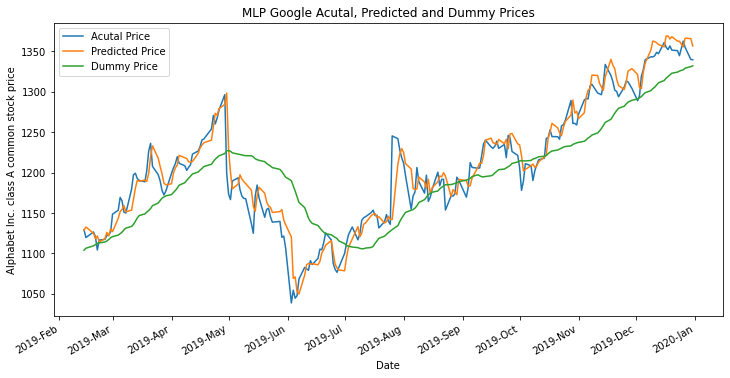

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

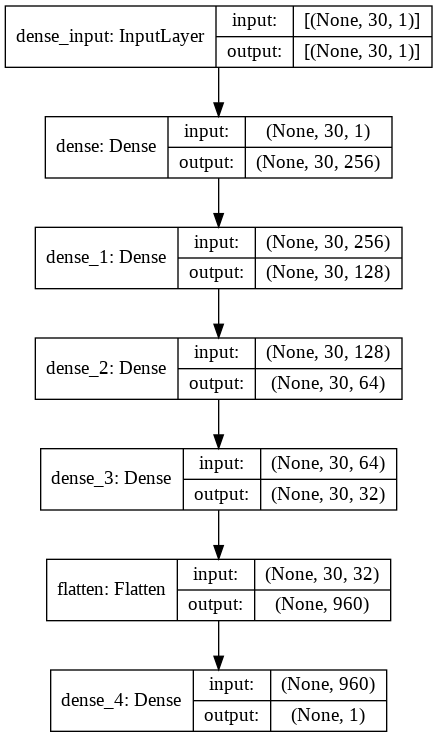

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.004168326390407581
RMSE:  0.06456257732160002
MAE:  0.046966167131904143
Dummy MSE:  0.01786933010743511
Dummy RMSE:  0.13367621369351806
Dummy MAE:  0.10749275974657799


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_Google/assets
